In [ ]:
import numpy as np
import pandas as pd
import os
from dmx.stats import * 
from dmx.utils.estimation import optimize, best_of
from typing import Optional

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

PATH_TO_DATA = "../data/malware"
TRAIN_DATA = os.path.join(PATH_TO_DATA, "malware_conditional_train.csv")
TEST_DATA = os.path.join(PATH_TO_DATA, "malware_conditional_test.csv")

# load in the train and test data
train_df = pd.read_csv(TRAIN_DATA)
test_df = pd.read_csv(TEST_DATA)

T0 = tuple[str, int, float, int, Optional[str], Optional[str], Optional[str], Optional[int]]
T1 = tuple[int, float, int, Optional[str], Optional[str], Optional[str], Optional[int]]

## EDA
Let's begin by taking a look at the data and doing a basic exploratory data analysis. We can peak at the top of our test data set to get an idea of what data types we are dealing with. Our goal here will be associating the correct `user_id` with the observation. 

In [12]:
test_df.head()

,user_id,packet_size,session_duration,failed_logins,protocol_type,encryption,browser_type,attack_detected
0,user_91,279,204.580258,6,UDP,DES,Chrome,1
1,user_251,818,802.662910,5,UDP,DES,Chrome,1
2,user_181,282,199.905495,5,TCP,DES,NaN,1
3,user_373,292,199.346778,4,TCP,DES,Chrome,1
4,user_426,387,299.933410,1,TCP,AES,Edge,1


It looks like we have each data observation consists of a `user_id` (str), `packet_size` (int), `session_duration` (float), `failed_logins` (int), `protocol_type` (str), `encryption` (str), `browser_type` (str), `attack_detected` (int). 

Peaking to the training data, we can see that some columns contain missing data. 

In [58]:
def find_columns_with_missing_data(df: pd.DataFrame) -> list[str]:    
    missing = []
    for col in train_df.columns:
        missing_cnt = np.mean(df[col].isnull())
        if missing_cnt > 0.0:
            print(f"{col} has{missing_cnt*100: 0.2f}% missing data.")
            missing.append(col)

    return missing

missing_column_names = find_columns_with_missing_data(train_df)

protocol_type has 19.18% missing data.
encryption has 17.07% missing data.
browser_type has 20.95% missing data.
attack_detected has 89.84% missing data.


In [71]:
missing_column_names

['protocol_type', 'encryption', 'browser_type', 'attack_detected']

In [ ]:
user_ids = train_df["user_id"].unique().tolist()
num_users = len(user_ids)
print(f"There are {num_users} unique users.")

There are 500 unique users.


We can take a look at how many samples per user we have.

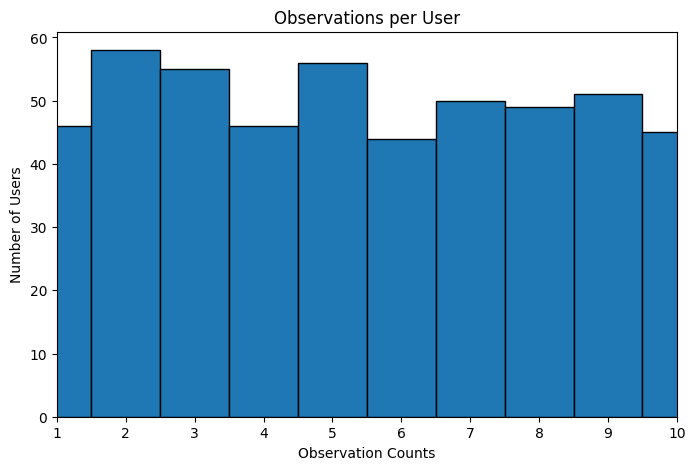

In [56]:
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(train_df['user_id'].value_counts(), bins=range(1, 12), edgecolor='black', align='left')
plt.title("Observations per User")
plt.xlabel("Observation Counts")
plt.ylabel("Number of Users")
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.show()

It looks like some users have low observation counts. If we build up a model using validation data we will want to stratify our data in a way that ensures we have at least one sample for each user. 

Before we create a validation set, we should clean up some of the missing value data. I am going to map the "nan" values from the `DataFrame` objects to `None`. We can use the `OptionalEstimator` to help handle the missing values later on. 

Now let's take a look at the numeric data (none of this data is missing). 

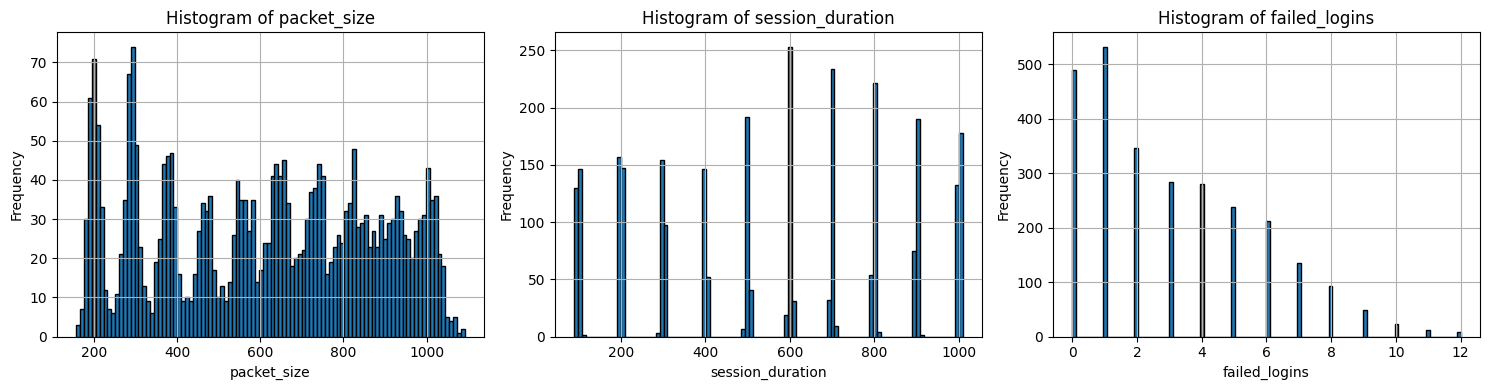

In [117]:
# Select the columns to plot
cols = ["packet_size", "session_duration", "failed_logins"]

plt.figure(figsize=(15, 4))  # Wide layout for 3 side-by-side plots

for i, col in enumerate(cols, 1):
    plt.subplot(1, 3, i)
    train_df[col].hist(bins=100, edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


`session_duration` looks like it splits into 10 groups. This is not neccesarily telling of anything, but we can just keep that in mind. `failed_logins` will require a distribution that supports the non-negative integers. `packet_size` is discrete, but if we wanted to, we could get away with using a continuous approximation. 

In [119]:
print(f"The smallest session_duration value is {train_df["session_duration"].min(): 0.2f}")

The smallest session_duration value is  90.22


Let's also take a look at the possible categorical values for the features. Keep in mind these all have missing data as well!

In [131]:
protocol_types = train_df["protocol_type"].dropna().unique().tolist()
encryption_types = train_df["encryption"].dropna().unique().tolist()
browser_types = train_df["browser_type"].dropna().unique().tolist()

print(f"Protocol Types: {protocol_types}")
print(f"Encryption Types: {encryption_types}")
print(f"Browser Types: {browser_types}")


Protocol Types: ['TCP', 'UDP', 'DNS']
Encryption Types: ['DES', 'AES']
Browser Types: ['Firefox', 'Edge', 'Chrome', 'Safari']


Alright, now we should write our data from a list to make it easier to work with for building `dmx-learn` distributions. We are also going to pop in a `None` value for missing data in each observation. 

In [134]:
def df_to_list(train_df: pd.DataFrame, test_df: pd.DataFrame):

    missing_values = train_df.isna().values
    train_data = train_df.values.copy()
    # set the nan / missing data to None
    train_data[missing_values] = None
    train_data = train_data.tolist()

    test_data = test_df.values.tolist()

    return train_data, test_data

train_data_list, test_data = df_to_list(train_df, test_df)

Printing out a few observations.

In [133]:
for x in train_data_list[:5]:
    print(x)

['user_0', 576, 503.68222700038007, 1, 'TCP', 'DES', 'Firefox', None]
['user_0', 960, 898.8108246200803, 0, 'UDP', 'DES', 'Edge', None]
['user_1', 687, 701.9890552889099, 0, 'TCP', 'AES', 'Edge', None]
['user_1', 294, 200.10028834875615, 7, 'TCP', 'DES', 'Chrome', None]
['user_1', 635, 603.7229153946557, 10, 'UDP', 'DES', 'Edge', None]


Next we will form a validation and training split. We want to make sure that users that have few observations are not withheld exclusively for validation, as this would cause numeric instability.

In [112]:
# create a train / validation split 
def data_per_doc(data, seed):
    sz = len(data)
    validation_samples = int(0.10 * sz)
    idx = np.random.RandomState(seed).permutation(sz)

    # count samples per id
    docs_per_user = {k: 0 for k in user_ids}
    for x in data:
        docs_per_user[x[0]] += 1
    

    train_data = []
    valid_data = []
    for i in idx:
        x = data[i]
        user_id = x[0]
        # try to add validation sample if at least 2 samples stil remain in train set
        if len(valid_data) < validation_samples:
            if 2 <= docs_per_user[user_id]:
                valid_data.append(data[i])
                docs_per_user[user_id] -= 1
            else:
                train_data.append(data[i])
        else:
            train_data.append(data[i])

    return train_data, valid_data


train_data, valid_data = data_per_doc(seed=1, data=train_data_list)


## Conditional Mixture Model
We are first going to build up a `ConditionalDistribution` where each user id is modeled by a `MixtureDistribution` with shared components. That means that each user model will differ only by the weights of its `MixtureDistribution`. 

We need to think about the format we will place the data in in order to write a `dmx` estimator wrapper. To do this, let's return to the data

- **user_id** (str): 500 unique user ids - Model this with `CategoricalEstimator`
- **packet_size** (int): Positive integer - Model this with `PoissonEstimator`
- **session_duration** (float): Positive float - Model this with a `GaussianEstimator`
- **failed_logins** (int): Non-negative integer - Model this with a `PoissonEstimator`
- **protocol_type** (optional[str]): 3 categories with missing data - `CategoricalEstimator` with `OptionalEstimator` wrapper
- **encryption** (optional[str]): 2 categories with missing data - `CategoricalEstimator` with `OptionalEstimator` wrapper
- **browser_type** (optional[str]): 4 categories with missing data - `CategoricalEstimator` with `OptionalEstimator` wrapper
- **attack_detected** (optional[bool]): binary value with missing data - `CategoricalEstimator` with `OptionalEstimator` wrapper

One thing to note here. We are going to assume that the `attack_detected` feature is not missing at random. It is strictly missing due to hand labeling. We will show how this can be used in the `OptionalEstimator` wrapper. 

### Defining the initial estimator with flattening
First we are going to define the initial estimator and flatten the categorical data to ensure there are no-numeric instabilities on initialization. We can easily do this by defining sufficient statistics for the `CategoricalEstimator` objects as below:

In [146]:
ss_proto = {k: 1.0 / len(protocol_types) for k in protocol_types}
ss_enc = {k: 1.0 / len(encryption_types) for k in encryption_types}
ss_browser = {k: 1.0 / len(browser_types) for k in browser_types}

# init estimate the prob on these
iest0 = CategoricalEstimator(suff_stat=ss_proto, pseudo_count=1.0)
iest1 = CategoricalEstimator(suff_stat=ss_enc, pseudo_count=1.0)
iest2 = CategoricalEstimator(suff_stat=ss_browser, pseudo_count=1.0)

Since all of these categoricals have missing data (and we assume missing at random), we can pass the estimators to the `OptionalEstimator` wrapper and flag `est_prob=True`.

In [164]:
iest_proto = OptionalEstimator(iest0, est_prob=True)
iest_enc = OptionalEstimator(iest1, est_prob=True)
iest_browser = OptionalEstimator(iest2, est_prob=True)

To define the estimator for `attack_detected`, we can simply pass a `CategoricalEstimator` to `OptionalEstimator` with `est_prob=False`. 

In [165]:
est_attack = OptionalEstimator(CategoricalEstimator(), est_prob=False)


Next we can define the estimators for the numeric data. We will also define the estimators for the categorical data without flattening. 

In [166]:
est_packet = PoissonEstimator()
est_duration = GaussianEstimator()
est_login = PoissonEstimator()

# no flattening for Categorical features
est_proto = OptionalEstimator(CategoricalEstimator(), est_prob=True)
est_enc = OptionalEstimator(CategoricalEstimator(), est_prob=True)
est_browser = OptionalEstimator(CategoricalEstimator(), est_prob=True)

Since we begin with a `ConditionalDistributionEstimator`, we will form a `CompositeEstimator` for the tuple of data features. Below we form the initial estimator.

In [167]:
iest_tuple = CompositeEstimator([est_packet, est_duration, est_login, iest_proto, iest_enc, iest_browser, est_attack])
iest_mix = MixtureEstimator([iest_tuple] * 10, keys=(None, "icomps"), suff_stat=np.ones(10) / 10., pseudo_count=1.0)
iest = ConditionalDistributionEstimator(estimator_map={k: iest_mix for k in user_ids})

We will also define the estimator

In [168]:
est_tuple = CompositeEstimator([est_packet, est_duration, est_login, est_proto, est_enc, est_browser, est_attack])
est_mix = MixtureEstimator([est_tuple] * 10, keys=(None, "comps"), suff_stat=np.ones(10)/10., pseudo_count=1.0)
est = ConditionalDistributionEstimator(estimator_map={k: iest_mix for k in user_ids})

Now we can make a call to `best_of` to find the best fitting model. Notice we had to reformat our data (see `data` and `vdata`) for the `ConditionalDistribtionEstimator` use case.

In [169]:
_, mm = best_of(
    data=[(x[0], x[1:]) for x in train_data],
    est=est,
    trials=5,
    init_p=0.10,
    vdata=[(x[0], x[1:]) for x in valid_data],
    delta=1.0e-6,
    max_its=100,
    print_iter=25,
    rng=np.random.RandomState(10),
    init_estimator=iest
)

Iteration 25. LL=-39031.350775, delta LL=1.459123e+00
Iteration 50. LL=-39026.898875, delta LL=6.256017e-04
Iteration 75. LL=-39026.895838, delta LL=1.173002e-05
Trial 1. VLL=-4515.407101
Iteration 25. LL=-41785.614001, delta LL=1.415987e+00
Trial 2. VLL=-4766.888297
Iteration 25. LL=-39032.222108, delta LL=1.008385e+00
Iteration 50. LL=-39017.009003, delta LL=1.651022e-01
Iteration 75. LL=-39014.690075, delta LL=6.664680e-02
Iteration 100. LL=-39014.065740, delta LL=8.911968e-03
Trial 3. VLL=-4507.518830
Iteration 25. LL=-35528.965132, delta LL=1.698484e-02
Trial 4. VLL=-4187.637550
Iteration 25. LL=-34636.711300, delta LL=1.399575e+00
Iteration 50. LL=-34622.578475, delta LL=5.737518e-01
Iteration 75. LL=-34618.511447, delta LL=7.471936e-04
Iteration 100. LL=-34618.508483, delta LL=3.138470e-05
Trial 5. VLL=-4033.139241


Now we can iterate on the best fitting model with a call to `optimize`

In [170]:
fit = optimize(
    data=[(x[0], x[1:]) for x in train_data],
    estimator=est,
    prev_estimate=mm,
    max_its=100,
    print_iter=10)

Iteration 10: ln[p_mat(Data|Model)]=-3.461851e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.241969e-05
Iteration 20: ln[p_mat(Data|Model)]=-3.461851e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=4.713322e-06
Iteration 30: ln[p_mat(Data|Model)]=-3.461851e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.764303e-06
Iteration 40: ln[p_mat(Data|Model)]=-3.461851e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=6.574046e-07
Iteration 50: ln[p_mat(Data|Model)]=-3.461851e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=2.444576e-07
Iteration 60: ln[p_mat(Data|Model)]=-3.461851e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=9.092764e-08
Iteration 70: ln[p_mat(Data|Model)]=-3.461851e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=3.369496e-08
Iteration 80: ln[p_mat(Data|Model)]=-3.461851e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.258013e-08
Iteration 90: ln[p_mat(Data|Model)]=-3.461851e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=4.743

In [171]:

def conditional_mixture_search_depth(model: MixtureDistribution, test_data):
    # Make a test case for each user
    sz = len(test_data)
    true_labels = np.asarray([int(x[0].split("_")[-1]) for x in test_data], dtype=int)

    # sequence encode the data for each mixture model.
    enc_test_data = seq_encode(data=[x[1:] for x in test_data], model=model.dmap["user_0"])[0][1]

    ll = np.zeros((sz, num_users))
    for i, x in enumerate(user_ids):
        # user each user_id model to score all the data
        ll[:, i] = model.dmap[x].seq_log_density(enc_test_data)

    # find the location of the true index in the ordered user likelihoods
    sd = np.argmax(np.argsort(-ll, axis=1) == true_labels[:, None], axis=1)
    # return the sorted search depths

    return np.sort(sd)

    

In [172]:
def plot_conditional_search_depth(search_depth):

    # Compute empirical CDF
    sd_y = np.arange(1, len(search_depth) + 1) / len(search_depth)  # P(X <= x)

    # Plot empirical CDF
    plt.figure(figsize=(8, 5))
    plt.plot(search_depth, sd_y, drawstyle="steps-post", linewidth=2)

    # Labels and title
    plt.xlabel("Number of Users", fontsize=12)
    plt.ylabel("P(X ≤ x)", fontsize=12)
    plt.title("User Search Depth", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.show()

In [173]:
sd_conditional = conditional_mixture_search_depth(fit, test_data)

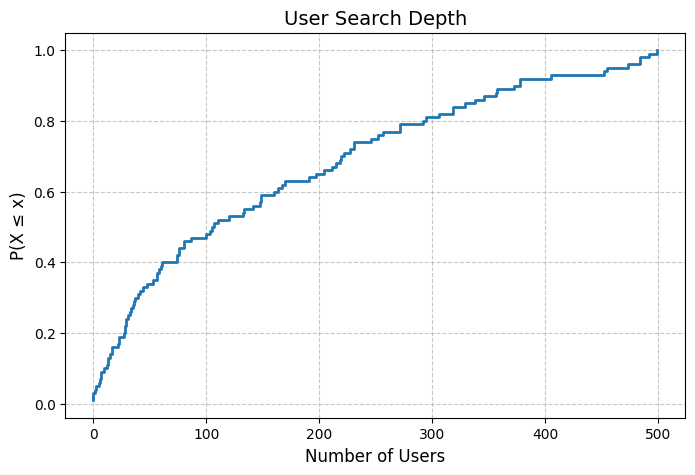

In [174]:
plot_conditional_search_depth(sd_conditional)

## Composite Mixture Model

The conditional composite mixture model works out to be a `MixtureDistribtion` where the mixture components are shared for each user. The fit was slow, and we are essentially only performing this fix to obtain user-weights to re-weight the mixture model. 

Let's take a look at a different approach. Instead of fitting a `ConditionalDistribution`, we are simply going to use a `CompositeEstimator` and add in a `CategoricalEstimator` for each `user_id`. Let's see how this looks. 

In [229]:
# flatten for all users in the initial estimator
iest_user = CategoricalEstimator(suff_stat={k: 1.0 / num_users for k in user_ids}, pseudo_count=1.0)
# add the initial user estimator to the tuple
iest_tuple = CompositeEstimator([iest_user, est_packet, est_duration, est_login, iest_proto, iest_enc, iest_browser, est_attack])
# initial composite mixture estimator
iest = MixtureEstimator([iest_tuple] * 10, keys=(None, "icomps"), suff_stat=np.ones(10) / 10., pseudo_count=1.0)

We also need an estimator without flattening.

In [230]:
# user estimator
est_user = CategoricalEstimator()
# add the user estimator to the tuple
est_tuple = CompositeEstimator([est_user, est_packet, est_duration, est_login, est_proto, est_enc, est_browser, est_attack])
# composite mixture estimator
est = MixtureEstimator([iest_tuple] * 10, keys=(None, "comps"), suff_stat=np.ones(10) / 10., pseudo_count=1.0)

We can make a call to `best_of` again to find the best fitting model on the validation data for 5 different initial conditions. Notice this time that we do not need to alter the `data` or `vdata` argument in anyway, as the data is now supported on each row of the original dataframe as is.

In [231]:
_, comp_mix_best = best_of(
    data=train_data,
    est=est,
    trials=5,
    init_p=0.10,
    vdata=valid_data,
    delta=1.0e-6,
    max_its=100,
    print_iter=25,
    rng=np.random.RandomState(10),
    init_estimator=iest
)

Iteration 25. LL=-52869.410916, delta LL=8.177584e-01
Iteration 50. LL=-52823.832489, delta LL=3.379453e-01
Iteration 75. LL=-52820.844510, delta LL=1.800600e-02
Iteration 100. LL=-52819.501388, delta LL=9.088609e-03
Trial 1. VLL=-6261.568423
Iteration 25. LL=-56249.399366, delta LL=1.066126e+00
Iteration 50. LL=-56228.740210, delta LL=7.079255e-01
Iteration 75. LL=-56221.794797, delta LL=3.976919e-01
Iteration 100. LL=-56207.647813, delta LL=2.234724e-02
Trial 2. VLL=-6540.019235
Iteration 25. LL=-52725.546329, delta LL=1.137085e+00
Iteration 50. LL=-52711.038550, delta LL=2.014120e-01
Iteration 75. LL=-52706.893847, delta LL=1.029151e-02
Iteration 100. LL=-52706.566405, delta LL=4.315825e-03
Trial 3. VLL=-6220.196353
Iteration 25. LL=-56251.691713, delta LL=1.275444e+00
Iteration 50. LL=-56228.325277, delta LL=1.238459e+00
Iteration 75. LL=-56201.362501, delta LL=7.483712e-01
Iteration 100. LL=-56189.530419, delta LL=1.988411e-01
Trial 4. VLL=-6541.821584
Iteration 25. LL=-49989.7940

That was much faster. Let's iterate on the best fit a little bit.

In [232]:
comp_mix_fit = optimize(
    data=train_data,
    estimator=est,
    prev_estimate=comp_mix_best,
    max_its=1000,
    delta=1.0e-9,
    print_iter=50)

Iteration 50: ln[p_mat(Data|Model)]=-4.995742e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=4.154095e-02
Iteration 100: ln[p_mat(Data|Model)]=-4.995699e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=3.100136e-05
Iteration 101: ln[p_mat(Data|Model)]=-4.995699e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=-1.706995e-05


Alright, now we have fit the mixture model to all of the data. We still want to perform a search depth over the space of all the users for the test data. 

In [233]:
def get_user_posteriors(model: MixtureDistribution):
    # Get P(User id | Z = z) from each mixture component
    user_components = [comp.dists[0] for comp in model.components]
    # get the weights from the mixture model P(Z=z)
    w = model.w
    # Make user mixture P(user id) = sum_{z} P(User id | Z=z) P(Z=z)
    user_mix = MixtureDistribution(components=user_components, w=w)
    # Encode the list of all user ids in order
    enc_users = seq_encode(data=user_ids, model=user_mix)[0][1]
    # Get P(Z=z | user_id = i) for i = 1, 2, ...., num_users
    user_post = user_mix.seq_posterior(enc_users)

    return user_post

user_posteriors = get_user_posteriors(comp_mix_fit)

In [234]:
def composite_mixture_search_depth(model: MixtureDistribution, posteriors: np.ndarray, test_data: T0):
    sz = len(test_data)
    # pop off the user_id from the test data
    data = [x[1:] for x in test_data]
    # store the true labels
    true_labels = np.asarray([int(x[0].split("_")[-1]) for x in test_data], dtype=int)
    

    # We want \prod_{i \neq user_id} P(X_{i}| Z=z) P(Z=z), excluding the User id 
    mix_comps = [CompositeDistribution(dists=comp.dists[1:]) for comp in model.components]

    # Form the mixture model without the user id component
    mix_model = MixtureDistribution(components=mix_comps, w=model.w)
    # Encode the data (without the user ids)
    enc_data = seq_encode(data=data, model=mix_model)[0][1]

    # create loglike variable to store scores for each user
    ll = np.zeros((sz, num_users))
    for i in range(num_users):
        ll[:, i] = MixtureDistribution(components=mix_comps, w=posteriors[i]).seq_log_density(enc_data)

    # find the location of the true index in the ordered user likelihoods
    sd = np.argmax(np.argsort(-ll, axis=1) == true_labels[:, None], axis=1)
    # return the sorted search depths

    return np.sort(sd)

sd_composite_mix = composite_mixture_search_depth(comp_mix_fit, user_posteriors, test_data)

In [ ]:
def plot_composite_mixture_search_depth(search_depth_composite, search_depth_conditional):

    # make CDF for data
    user_cdf = np.arange(1, len(search_depth_composite) + 1) / len(search_depth_composite) 
    # sort search_depths
    ranks_composite = np.sort(search_depth_composite)
    ranks_conditional = np.sort(search_depth_conditional)
    # Plot both CDFs
    plt.figure(figsize=(8, 5))

    plt.plot(ranks_composite, user_cdf, drawstyle="steps-post", linewidth=2, linestyle="--", label="Composite", color="orange")
    plt.plot(ranks_conditional, user_cdf, drawstyle="steps-post", linewidth=2, linestyle="--", label="Conditional", color="blue")

    # Labels, title, legend
    plt.xlabel("Number of Users Searched", fontsize=12)
    plt.ylabel("P(X ≤ x)", fontsize=12)
    plt.title("User Search Depth", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.show()

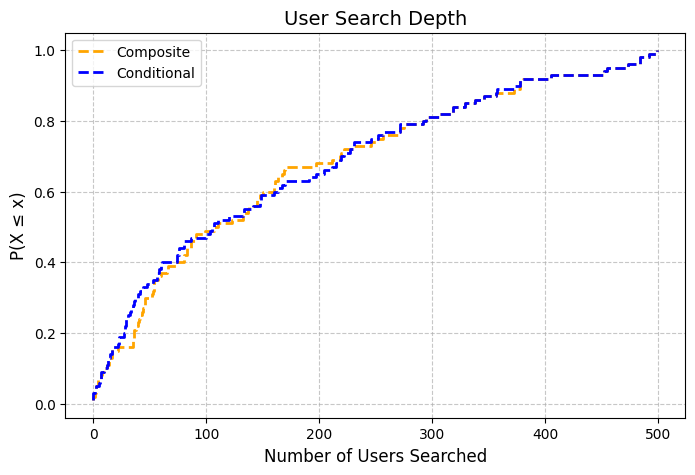

In [236]:
plot_composite_mixture_search_depth(sd_composite_mix, sd_conditional)

As expected, we see that the models are virtually identical (numeric error ect.). This is not surprising, can in fact be viewed as a low-rank (smoothed) approximation to the conditional model. To see this try re-fitting with 3, 5, 8 mixture components and plotting the results. 

### One more trick for grouping the user ids

Instead of throwing in the `CategoricalEstimator` for the composite mixture model, we could have also just grouped our data and computed the posteriors for each user via expectation. Let's see what this looks like.

We can use the same estimators as for the composite mixture model. We are just going to ignore the `user_id` estimator and exclude it from the training / validation data.

In [237]:
# add the initial user estimator to the tuple
iest_tuple = CompositeEstimator([est_packet, est_duration, est_login, iest_proto, iest_enc, iest_browser, est_attack])
# initial composite mixture estimator
iest = MixtureEstimator([iest_tuple] * 10, keys=(None, "icomps"), suff_stat=np.ones(10) / 10., pseudo_count=1.0)

# add the user estimator to the tuple
est_tuple = CompositeEstimator([est_packet, est_duration, est_login, est_proto, est_enc, est_browser, est_attack])
# composite mixture estimator
est = MixtureEstimator([iest_tuple] * 10, keys=(None, "comps"), suff_stat=np.ones(10) / 10., pseudo_count=1.0)

We can call `best_of` again. We do need to pop-off the `user_id` bit of the `data` and `vdata` arguments.

In [238]:
_, exp_mix_best = best_of(
    data=[x[1:] for x in train_data],
    est=est,
    trials=5,
    init_p=0.10,
    vdata=[x[1:] for x in valid_data],
    delta=1.0e-6,
    max_its=100,
    print_iter=25,
    rng=np.random.RandomState(10),
    init_estimator=iest
)

Trial 1. VLL=-4893.894604
Trial 2. VLL=-4918.676151
Iteration 25. LL=-44487.377589, delta LL=4.635137e-01
Iteration 50. LL=-44485.205339, delta LL=5.807259e-03
Iteration 75. LL=-44484.995029, delta LL=1.098265e-02
Iteration 100. LL=-44484.644820, delta LL=1.657493e-02
Trial 3. VLL=-4919.318394
Trial 4. VLL=-4919.235527
Trial 5. VLL=-4679.696413


We can also iterate a bit more if needed...

In [239]:
exp_mix_fit = optimize(
    data=[x[1:] for x in train_data],
    estimator=est,
    prev_estimate=exp_mix_best,
    max_its=1000,
    delta=1.0e-9,
    print_iter=50)

Iteration 1: ln[p_mat(Data|Model)]=-4.194393e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=-4.275009e+00


In [258]:
def posterior_by_user(train_data: T0, model: MixtureDistribution) -> np.ndarray:
    # group the data by user
    data_by_user = {k: [] for k in user_ids}
    for x in train_data:
        data_by_user[x[0]].append(x[1:])
    
    user_posteriors = np.zeros((num_users, model.num_components))
    for i, k in enumerate(user_ids):
        user_enc_data = seq_encode(data=data_by_user[k], model=model)[0][1]
        # get average posterior for each user over the training set
        user_posteriors[i] = np.mean(model.seq_posterior(user_enc_data), axis=0)

    return user_posteriors

user_posteriors = posterior_by_user(train_data, exp_mix_fit)

In [259]:
user_posteriors

array([[0.00000000e+000, 7.08941442e-084, 0.00000000e+000, ...,
        5.14901614e-194, 1.24743483e-232, 1.60545624e-291],
       [0.00000000e+000, 6.66666667e-001, 1.72878153e-200, ...,
        2.02252486e-213, 1.27199140e-268, 0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       ...,
       [0.00000000e+000, 3.33333333e-001, 1.53409350e-192, ...,
        3.03880221e-221, 6.84916040e-267, 3.33333333e-001],
       [0.00000000e+000, 2.00000000e-001, 4.00000000e-001, ...,
        1.01807453e-200, 1.64506744e-240, 3.27616680e-274],
       [0.00000000e+000, 1.96501834e-103, 0.00000000e+000, ...,
        4.25591994e-001, 1.10743381e-001, 0.00000000e+000]],
      shape=(500, 10))

In [260]:
def mean_composite_mixture_search_depth(model: MixtureDistribution, posteriors: np.ndarray, test_data: T0):
    sz = len(test_data)
    # pop off the user_id from the test data
    data = [x[1:] for x in test_data]
    # store the true labels
    true_labels = np.asarray([int(x[0].split("_")[-1]) for x in test_data], dtype=int)
    
    # Encode the data (without the user ids)
    enc_data = seq_encode(data=data, model=model)[0][1]

    # create loglike variable to store scores for each user
    ll = np.zeros((sz, num_users))
    for i in range(num_users):
        ll[:, i] = MixtureDistribution(components=model.components, w=posteriors[i]).seq_log_density(enc_data)

    # find the location of the true index in the ordered user likelihoods
    sd = np.argmax(np.argsort(-ll, axis=1) == true_labels[:, None], axis=1)
    # return the sorted search depths

    return np.sort(sd)

sd_avg_composite_mix = mean_composite_mixture_search_depth(exp_mix_fit, user_posteriors, test_data)

In [262]:
def plot_avg_composite_mixture_search_depth(search_depth_avg_composite, search_depth_composite, search_depth_conditional):

    # make CDF for data
    user_cdf = np.arange(1, len(search_depth_composite) + 1) / len(search_depth_composite) 
    # sort search_depths
    ranks_avg_composite = np.sort(search_depth_avg_composite)
    ranks_composite = np.sort(search_depth_composite)
    ranks_conditional = np.sort(search_depth_conditional)
    # Plot both CDFs
    plt.figure(figsize=(8, 5))

    plt.plot(ranks_avg_composite, user_cdf, drawstyle="steps-post", linewidth=2, linestyle="--", label="Composite Approx", color="green")
    plt.plot(ranks_composite, user_cdf, drawstyle="steps-post", linewidth=2, linestyle="--", label="Composite", color="orange")
    plt.plot(ranks_conditional, user_cdf, drawstyle="steps-post", linewidth=2, linestyle="--", label="Conditional", color="blue")

    # Labels, title, legend
    plt.xlabel("Number of Users Searched", fontsize=12)
    plt.ylabel("P(X ≤ x)", fontsize=12)
    plt.title("User Search Depth", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.show()

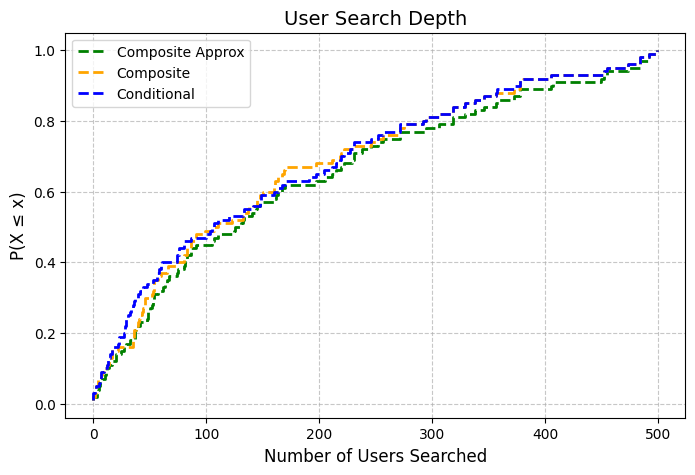

In [263]:
plot_avg_composite_mixture_search_depth(sd_avg_composite_mix, sd_composite_mix, sd_conditional)

We see the result is again quite similar. The benifit in this case is that we can skip adding in a `CategoricalEstimator` and simply group the data. This can be useful if you have many users and are only interested in comparing a subset of them.

### Unsupervised

One thing to note about the composite mixture model is that it is unsupervised. We did not need to specify a target when fitting this model. This will allow you pop off other components of the composite mixture and analyze a different variable with respect to the others. 


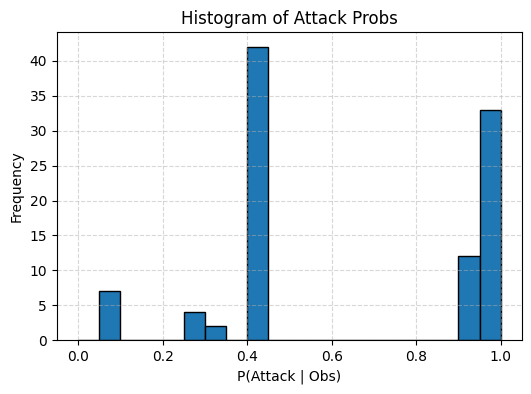

In [287]:
# pop off the attack detected and predict the 

def predict_attack_detected(test_data, model):
    # get the test attack labels
    attack_labels = np.asarray([x[-1] for x in test_data], dtype=int)
    # pop off the attack mixture comps (we keep user id)
    mix_comps = [CompositeDistribution(x.dists[:-1]) for x in model.components]
    # Mixture model P(X_{i \neq attack detected} | Z=z) P(Z=z)
    mix_model = MixtureDistribution(components=mix_comps, w=model.w)

    # Get components for the attack model
    attack_comps = [x.dists[-1] for x in model.components]

    scores = []
    for x in test_data:
        # P(Z=z | test_obs)
        posterior = mix_model.posterior(x[:-1])
        # Get P(Attack | Z=z) P(Z=z | test_obs)
        attack_mix = MixtureDistribution(attack_comps, w=posterior)
        # get log(P(X=1 | test obs))
        scores.append(attack_mix.log_density(1))

    scores = np.exp(scores)
    plt.figure(figsize=(6,4))
    plt.hist(scores, bins=20, range=(0, 1), edgecolor='black')
    plt.xlabel("P(Attack | Obs)")
    plt.ylabel("Frequency")
    plt.title("Histogram of Attack Probs")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

predict_attack_detected(test_data, comp_mix_fit)


Since all of the test data corresponds to attacks that were detected, we can not make an ROC curve. We can however look at the posterior predictive weights for $$P\left(\text{Attack Detected} \vert \text{Test Observation}\right)$$

We can generate cases of data where an attack should be detected. 

In [299]:
def generate_attack_data(seed, size): 
    attack_mixture = MixtureDistribution([comp.dists[-1] for comp in comp_mix_fit.components], w=comp_mix_fit.w)
    attack_posterior = attack_mixture.posterior(1)

    mix_given_attack = MixtureDistribution(components=[CompositeDistribution(comp.dists[:-1]) for comp in comp_mix_fit.components], w=attack_posterior)
    sampler = mix_given_attack.sampler(seed=seed)

    attack_data = sampler.sample(size)

    return attack_data

In [302]:
sampled_data = generate_attack_data(seed=1, size=10)
sampled_data

[('user_265', 229, 156.68343894136777, 4, 'UDP', 'AES', 'Chrome'),
 ('user_349', 354, 298.41196658936707, 1, 'TCP', None, 'Edge'),
 ('user_189', 484, 400.27101272547475, 4, None, 'AES', 'Edge'),
 ('user_99', 270, 82.97781055871377, 3, 'UDP', 'AES', 'Safari'),
 ('user_364', 386, 294.82400761247135, 0, None, 'DES', None),
 ('user_373', 236, 160.39532873834995, 2, 'TCP', 'AES', 'Safari'),
 ('user_168', 947, 959.0124315404867, 0, 'DNS', 'DES', None),
 ('user_369', 272, 94.65441367952862, 9, 'UDP', 'AES', 'Chrome'),
 ('user_331', 268, 132.90124499461567, 2, 'UDP', 'AES', 'Chrome'),
 ('user_435', 836, 796.5554200499845, 7, 'UDP', 'DES', 'Safari')]